In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
import json
import os
import io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
DATASET_FOLDER = "./datasets"
DATASET_NAME = "sarcasm.json"
DATASET_URL  = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json"

In [3]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [4]:
!wget --no-check-certificate $DATASET_URL -O $DATASET_FOLDER/$DATASET_NAME

--2019-11-30 22:58:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘./datasets/sarcasm.json’

./datasets/sarcasm. 100%[===================>]   5.38M  17.4MB/s    in 0.3s    

2019-11-30 22:58:26 (17.4 MB/s) - ‘./datasets/sarcasm.json’ saved [5643545/5643545]



In [5]:
# Read the dataset
fullpath = os.path.join(DATASET_FOLDER, DATASET_NAME)
with open(fullpath, 'r') as f:
    datastore = json.load(f)

In [6]:
# Store the sentences and the labels
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
vocab_size = 1000
embedding_dim = 32
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [9]:
# Split the data in two :) 
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [10]:
# Create the tokenizer 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Encode the sentences
tokenizer.fit_on_texts(training_sentences)

# get the word index 
word_index = tokenizer.word_index

# Generate the sequences for training 
training_sequences = tokenizer.texts_to_sequences(training_sentences)

# Generate the pad for the sequences
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

# Generate the sequences for testing
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Generate the pad for the sequences
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [37]:
# Reverse the index as the key is the word and the value is the number
# We want it as: number: word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [38]:
# Create the model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
# Configure the model 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [40]:
# Print the summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 32)            32000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


In [41]:
print(training_padded.shape)
print(len(training_labels))
print(testing_padded.shape)
print(len(testing_labels))

(20000, 16)
20000
(6709, 16)
6709


In [43]:
# Train the model with 30 epochs 
num_epochs = 30

history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.4972 - acc: 0.7556 - val_loss: 0.4049 - val_acc: 0.8091
Epoch 2/30
20000/20000 - 1s - loss: 0.3756 - acc: 0.8263 - val_loss: 0.3976 - val_acc: 0.8167
Epoch 3/30
20000/20000 - 2s - loss: 0.3628 - acc: 0.8345 - val_loss: 0.4002 - val_acc: 0.8116
Epoch 4/30
20000/20000 - 1s - loss: 0.3579 - acc: 0.8347 - val_loss: 0.4036 - val_acc: 0.8117
Epoch 5/30
20000/20000 - 1s - loss: 0.3567 - acc: 0.8371 - val_loss: 0.4069 - val_acc: 0.8077
Epoch 6/30
20000/20000 - 1s - loss: 0.3537 - acc: 0.8386 - val_loss: 0.4049 - val_acc: 0.8147
Epoch 7/30
20000/20000 - 2s - loss: 0.3521 - acc: 0.8388 - val_loss: 0.4116 - val_acc: 0.8135
Epoch 8/30
20000/20000 - 2s - loss: 0.3507 - acc: 0.8388 - val_loss: 0.4125 - val_acc: 0.8043
Epoch 9/30
20000/20000 - 1s - loss: 0.3502 - acc: 0.8382 - val_loss: 0.4056 - val_acc: 0.8106
Epoch 10/30
20000/20000 - 2s - loss: 0.3467 - acc: 0.8415 - val_loss: 0.4108 - val_acc: 0.8061
Epoch 11/3

In [47]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

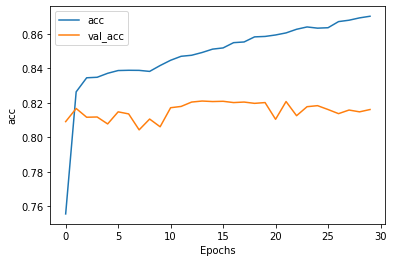

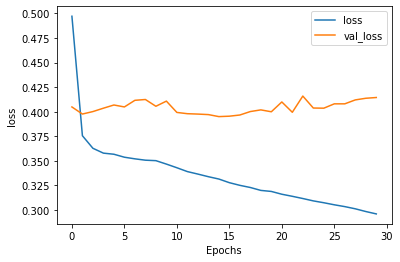

In [49]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [50]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [51]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 32)


In [55]:
out_v = io.open('vecs_sarcasm.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_sarcasm.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [56]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_sarcasm.tsv')
  files.download('meta_sarcasm.tsv')

In [57]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.65753436]
 [0.5363251 ]]
